In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
%matplotlib inline


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')
print(train.shape)
print(test.shape)
print(store.shape)

(1017209, 9)
(41088, 8)
(1115, 10)


D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
train['Year'] = train['Date'].apply(lambda x: int(x[:4]))
train['Month'] = train['Date'].apply(lambda x: int(x[5:7]))
train['Day'] = train['Date'].apply(lambda x: int(x[8:10]))
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31


In [6]:
test['Year'] = test['Date'].apply(lambda x: int(x[:4]))
test['Month'] = test['Date'].apply(lambda x: int(x[5:7]))
test['Day'] = test['Date'].apply(lambda x: int(x[8:10]))
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17


In [7]:
print(train[train['StateHoliday']=='a'].shape[0])
print(train[train['StateHoliday']=='b'].shape[0])
print(train[train['StateHoliday']=='c'].shape[0])
print(train[train['StateHoliday']=='0'].shape[0])
print(train[train['StateHoliday']==0].shape[0])

20260
6690
4100
855087
131072


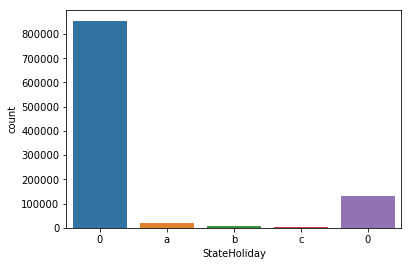

In [8]:
import seaborn as sns
sns.countplot(train['StateHoliday'])

In [9]:
train = train.replace({'StateHoliday': {'0': 0, 'a': 1, 'b': 2, 'c': 3}})
test = test.replace({'StateHoliday': {'0': 0, 'a': 1, 'b': 2, 'c': 3}})

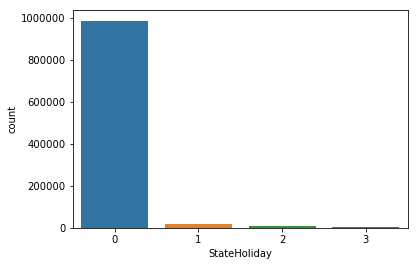

In [10]:
sns.countplot(train['StateHoliday'])

In [16]:
# 增加字段Pred
# train['Perd'] = train['Date'].apply(lambda x: (str(x)[:7]))
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Perd
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,2015-07
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,2015-07
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,2015-07
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,2015-07
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,2015-07


### 销售情况的变化

In [15]:
# average_sales = train.groupby('Perd')['Sales'].mean()
# pct_change_sales = train.groupby('Perd')['Sales'].sum().pct_change()
# fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
# ax1.set_xticks(range(len(average_sales)))
# ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

# pct_change_sales.plot(legend=True,ax=axis2,marker='x',rot=90,colormap="summer",title="Sales Percent Change")
# plt.show()

### 顾客的人数波动

In [14]:
# Customers_num = train.groupby('Perd')['Customers'].mean()
# fig, (axis1) = plt.subplots(1,1,sharex=True,figsize=(20,4))

# ax1 = Customers_num.plot(legend=True,ax=axis1,marker='o',title="Customers Num")
# ax1.set_xticks(range(len(Customers_num)))
# ax1.set_xticklabels(Customers_num.index.tolist(), rotation=90)

# plt.show()

### 一周内消费和顾客的平均变化

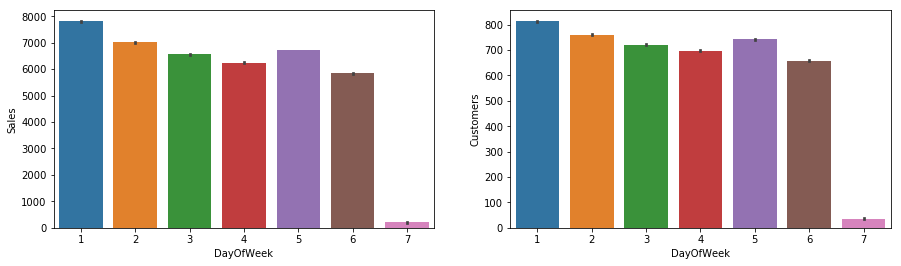

In [13]:
# shows the mean value
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x = 'DayOfWeek',y = 'Sales',data= train,ax = axis1)
sns.barplot(x='DayOfWeek',y ='Customers',data= train,ax = axis2)
plt.show()

### 促销和非促销的平均变化对比

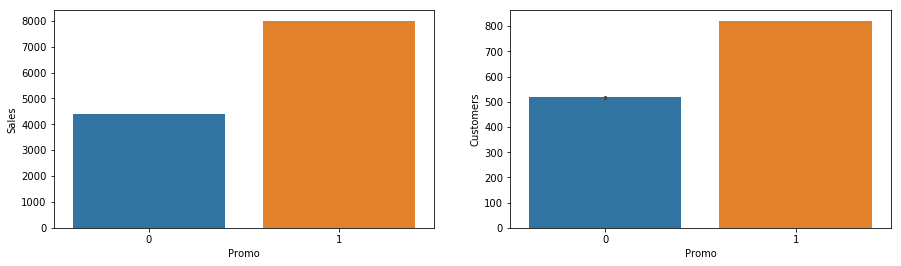

In [14]:
# shows the mean value
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x = 'Promo',y = 'Sales',data= train,ax = axis1)
sns.barplot(x='Promo',y ='Customers',data= train,ax = axis2)
plt.show()

### 节假日的平均销售对比

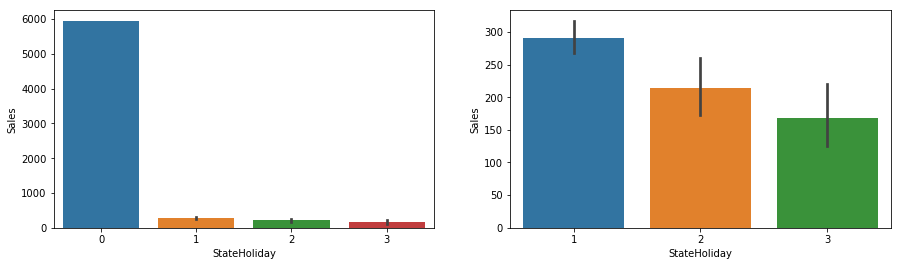

In [15]:
# shows the mean value
# 1 = public holiday, 2 = Easter holiday, 3 = Christmas, 0 = None
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='StateHoliday',y='Sales',data=train,ax=axis1)
sns.barplot(x='StateHoliday',y='Sales',data=train[(train['StateHoliday']!=0)],ax=axis2)
plt.show()

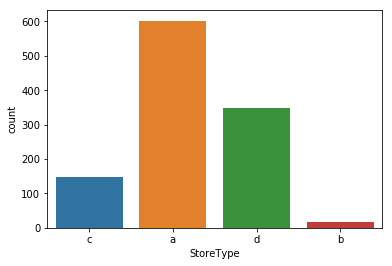

In [17]:
sns.countplot(store['StoreType'])

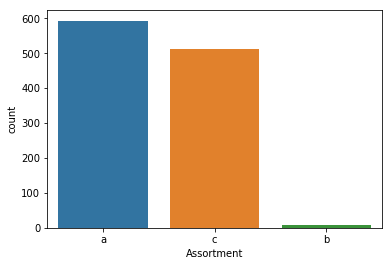

In [18]:
sns.countplot(store['Assortment'])

In [19]:
store = store.replace({'StoreType': { 'a': 0, 'b': 1, 'c': 2, 'd': 3}})
store = store.replace({'Assortment': { 'a': 0, 'b': 1, 'c': 2}})

In [20]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [21]:
train = train.merge(store, on='Store', how='left')
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Perd,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,2015-07,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,2015-07,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,2015-07,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,2015-07,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,2015-07,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [22]:
test = test.merge(store, on='Store', how='left')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,0,2,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,0,0,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,0,2,2030.0,8.0,2000.0,0,NaN,NaN,NaN


### 商店模式的对比

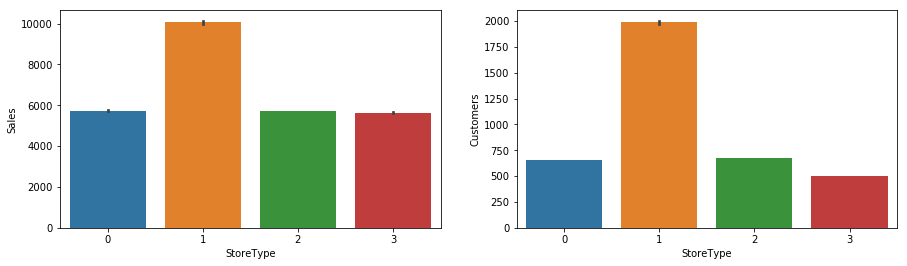

In [21]:
# 平均对比
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='StoreType',y='Sales',data=train,ax=axis1)
sns.barplot(x='StoreType',y='Customers',data=train,ax=axis2)
plt.show()

### 分类等级对比

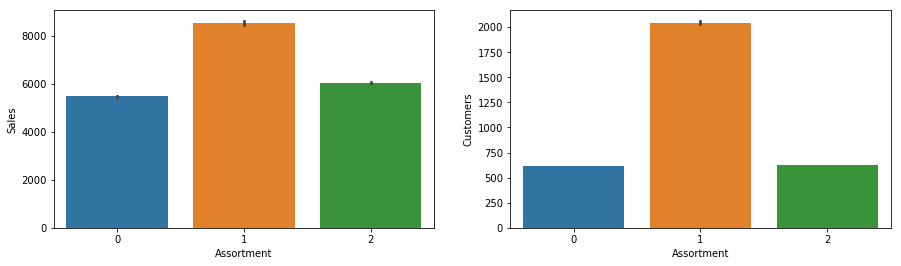

In [22]:
# 平均对比
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='Assortment',y='Sales',data=train,ax=axis1)
sns.barplot(x='Assortment',y='Customers',data=train,ax=axis2)
plt.show()

### 竞争者距离

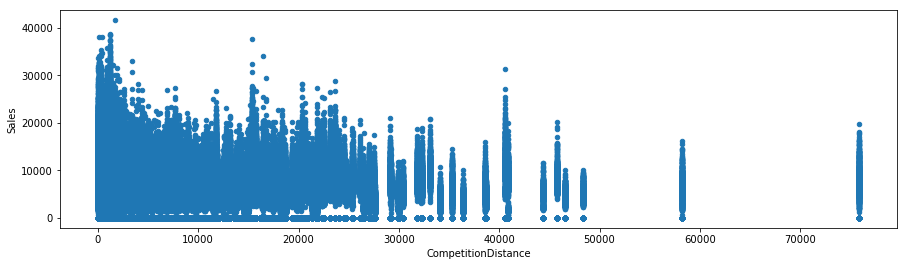

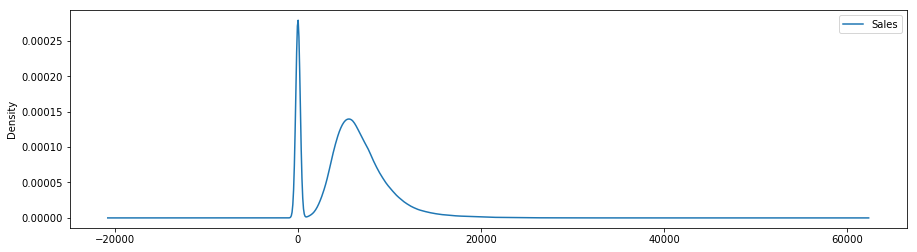

In [23]:
train['CompetitionDistance'].fillna(train['CompetitionDistance'].mean())
train.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4))
train.plot(kind='kde',x='CompetitionDistance',y='Sales',figsize=(15,4))
plt.show()

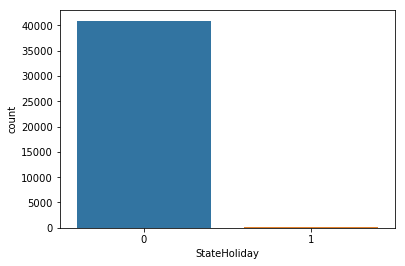

In [23]:
sns.countplot(test['StateHoliday'])

In [24]:
test.isnull().loc[:,'Open'].value_counts()

False    41077
True        11
Name: Open, dtype: int64

In [25]:
train.isnull().loc[:,'Open'].value_counts()

False    1017209
Name: Open, dtype: int64

In [26]:
test.Open.fillna(value=1, inplace=True)
test['Open'] = test['Open'].astype(int)
test['Open'].unique()

array([1, 0], dtype=int64)

In [28]:
train['CompetitionOpen'] = ((train['CompetitionOpenSinceYear'] < train['Year']) |\
                             ((train['CompetitionOpenSinceYear'] == train['Year']) &\
                              (train['CompetitionOpenSinceMonth'] <= train['Month']))).astype(int)

In [29]:
test['CompetitionOpen'] = ((test['CompetitionOpenSinceYear'] < test['Year']) |\
                             ((test['CompetitionOpenSinceYear'] == test['Year']) &\
                              (test['CompetitionOpenSinceMonth'] <= test['Month']))).astype(int)

In [32]:
train['PromoInterval'].fillna(0, inplace = True)

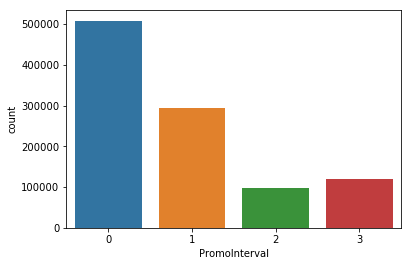

In [33]:
train = train.replace({'PromoInterval': {'Jan,Apr,Jul,Oct': 1, 'Mar,Jun,Sept,Dec': 2, 'Feb,May,Aug,Nov': 3}})
sns.countplot(train['PromoInterval'])

In [35]:
test['PromoInterval'].fillna(0, inplace = True)
test = test.replace({'PromoInterval': {'Jan,Apr,Jul,Oct': 1, 'Mar,Jun,Sept,Dec': 2, 'Feb,May,Aug,Nov': 3}})

In [38]:
test['Promo2SinceWeek'].fillna(0, inplace = True)
test['Promo2SinceYear'].fillna(0, inplace = True)
test['CompetitionDistance'].fillna(0, inplace = True)
test['CompetitionOpenSinceMonth'].fillna(0, inplace = True)
test['CompetitionOpenSinceYear'].fillna(0, inplace = True)

In [39]:
train['Promo2SinceWeek'].fillna(0, inplace = True)
train['Promo2SinceYear'].fillna(0, inplace = True)
train['CompetitionDistance'].fillna(0, inplace = True)
train['CompetitionOpenSinceMonth'].fillna(0, inplace = True)
train['CompetitionOpenSinceYear'].fillna(0, inplace = True)

In [42]:
X_temp = train.drop(['Sales','Date','Customers','Perd'], axis=1)
y_temp = train['Sales']

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=0)

In [48]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

clf_r = RandomForestRegressor()
clf_r.fit(X_train,y_train)
print('RandomForestRegressor',r2_score(clf_r.predict(X_val),y_val))

# clf = RandomForestRegressor(n_estimators=70,max_features='sqrt',max_depth=13)
# clf.fit(X_train,y_train)

# print('RandomForestRegressor',r2_score(clf_r.predict(X_val),y_val))

RandomForestRegressor 0.944836182329
